# EXERCISE 6 - Maschinelles Lernen: Grundlagen und Algorithmen -  SOLUTIONS

**Package notes:**
We will use different packages in this exersice:
1. Scipy:
    We will use scipy to solve linear systems of equations, given the Cholesky decomposition of the system matrix.
2. Sklearn:
    Sklearn is a package providing different machine learning algorithms and tools. We will not use it for machine learning algorithms here but for loading the handwritten image data set, which we will use for applying probabilistic PCA.
    
You can install all those packages using pip (or conda or whatever).

## 1.) k-Means (6 Points)
Here, we are going to implement one of the most basic appraoches to clustering - the $k$-Means algorithm. 
Let us start with some basic imports and implementing functionality to visualize our results. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def visualize_2d_clustering(data_points: np.ndarray, assignments_one_hot: np.ndarray, centers: np.ndarray, k: int,
                            centers_history: Optional[np.ndarray] = None, title: Optional[str] = None):
    """Visualizes clusters, centers and path of centers"""
    plt.figure(figsize=(6, 6), dpi=100)
    assignments = np.argmax(assignments_one_hot, axis=1)

    for i in range(k):
        # get next color
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        # get cluster
        cur_assignments = assignments == i
        # plot clusters
        plt.scatter(data_points[cur_assignments, 0], data_points[cur_assignments, 1], c=c, 
                    label="Cluster {:02d}".format(i))        
        # plot history of centers if it is given
        if centers_history is not None:
            plt.scatter(centers_history[:, i, 0], centers_history[:, i, 1], marker="x", c=c)
            plt.plot(centers_history[:, i, 0], centers_history[:, i, 1], c=c)

    plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="black", marker="X")

    if title is not None:
        plt.title(title)

    plt.legend()

Next, we are going to implement the actual algorithm. As a quick reminder, $k$-Means works by iterating the following steps until convergence (i.e., until assignment does not change anymore):

Start with $k$ random cluster centers.
* 1.) **Assignment step**: Given current cluster centers, assign each data point to the cluster with closest center.
* 2.) **Adjustment step**: Given current assignment, set cluster centers to the average of all data points assigned to it.
 
Implement the following two functions, which are supposed to perform these two steps.

***Hint***: as always, no for-loops are allowed!

In [2]:
def assignment_step(data_points: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Assignment step: computes assignments to cluster with closest center.
    :param data_points: data points (shape: [N x data_dim])
    :param centers: current cluster centers (shape: [k, data_dim])
    :return: new assignments (one-hot encoded) (shape: [N, k])
    """
    ############################################################
    # TODO: Implement the assignment step of the k-Means algorithm

    ## SOLUTION ################################################
    N, k = data_points.shape[0], centers.shape[0]

    # compute (squared) Eucledian distances of points to centers
    diffs = np.sum(np.square(data_points[:, None, :] - centers[None, :, :]), axis=-1)  # shape (N, k)

    # assign each point to closest mean
    assignments = np.argmin(diffs, axis=-1)  # shape (N,)

    # create one-hot encoded assignments
    # cf. https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
    assignments_one_hot = np.zeros(shape=(N, k))
    assignments_one_hot[np.arange(assignments.size), assignments] = 1.0
    ############################################################

    return assignments_one_hot

def adjustment_step(data_points: np.ndarray, assignments_one_hot: np.ndarray) -> np.ndarray:
    """
    Adjustment step: sets cluster centers to mean of data points assigned to them.
    :param data_points: data points (shape: [N x data_dim])
    :param assignments_one_hot: current assignment (one-hot encoded) (shape: [N, k])
    :return: new cluster centers (shape: [k, data_dim])
    """
    ############################################################
    # TODO: Implement the adjustment step of the k-Means algorithm

    ## SOLUTION ################################################
    points_per_cluster = data_points[:, None, :] * assignments_one_hot[:, :, None]  # shape (N, k, data_dim)
    sum_points_per_cluster = np.sum(points_per_cluster, axis=0)  # shape (k, data_dim)
    n_points_per_cluster = np.sum(assignments_one_hot, axis=0)  # shape (k,)
    new_centers = sum_points_per_cluster / n_points_per_cluster[:, None]  # shape(k, data_dim)
    ############################################################

    return new_centers

Now we can stitch together the $k$-Means algorithm.

In [3]:
def k_means(data_points: np.ndarray, k: int, max_iter: int = 100, vis_interval: int = 3) -> \
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Simple k-Means implementation.
    :param data_points: data points  (shape: [N x data_dim])
    :param k: number of clusters
    :param max_iter: maximum number of iterations to run if convergence is not reached
    :param vis_interval: after how many iterations to generate the next plot
    :return: - cluster labels (shape: [N])
             - means of clusters (shape: [k, data_dim])
             - history of SSDs over iterations (shape: [num_iters + 1])
             - history of means over iterations (shape: [num_iters + 1, k, data_dim])
    """
    # bookkeeping
    i = 0
    means_history = []
    ssd_history = []
    
    # start with dummy assignments (s.t. we enter loop)
    old_assignments = np.zeros(shape=[data_points.shape[0], k])
    new_assignments = np.ones(shape=[data_points.shape[0], k]) 

    # initialize with k random data points
    initial_idx = np.random.choice(len(data_points), k, replace=False)
    centers = data_points[initial_idx]

    # iterate while not converged and max number iterations not reached
    while np.any(old_assignments != new_assignments) and i < max_iter:            
        old_assignments = new_assignments
        
        # perform assignment 
        new_assignments = assignment_step(data_points, centers)
        
        # plot before adjustment
        if i % vis_interval == 0:
            visualize_2d_clustering(data_points, new_assignments, centers, k, title="Iteration {:02d}".format(i))
        
        # compute SSD before adjustment
        diffs = np.sum(np.square(data_points[:, None, :] - centers[None, :, :]), axis=-1)
        ssd_history.append(np.sum(new_assignments * diffs))
        
        # store cluster means before adjustment 
        means_history.append(centers.copy())
    
        # perform adjustment
        centers = adjustment_step(data_points, new_assignments)

        i += 1

    # compute final SSD
    diffs = np.sum(np.square(data_points[:, None, :] - centers[None, :, :]), axis=-1)
    ssd_history.append(np.sum(new_assignments * diffs))
    
    # store final cluster means 
    means_history.append(centers.copy())        
        
    print("Took", i, "iterations to converge")
    return new_assignments, centers, np.array(ssd_history), np.stack(means_history, 0)

Finally, we run $k$-Means on some datasets and visualize the results. We provide four datasets, each containing $500$ $2D$ samples. You can play around with the number of clustes, $k$, as well as the seed of the random number generator which influences the placement of the initial cluster centers.

Took 9 iterations to converge


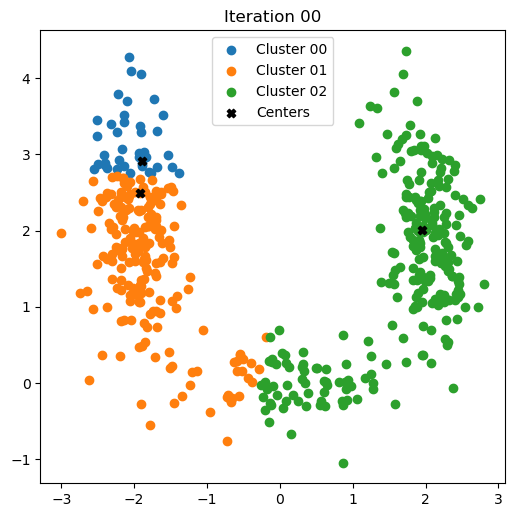

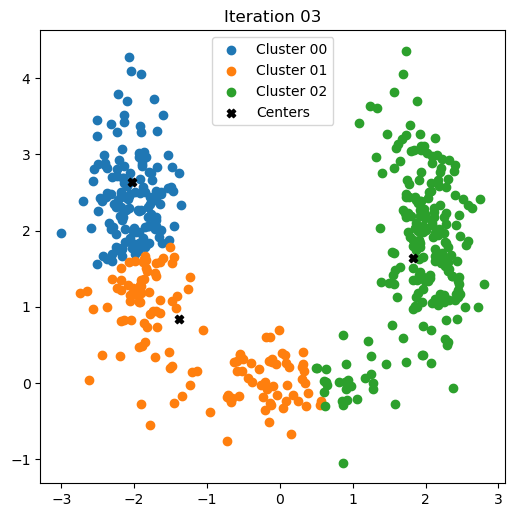

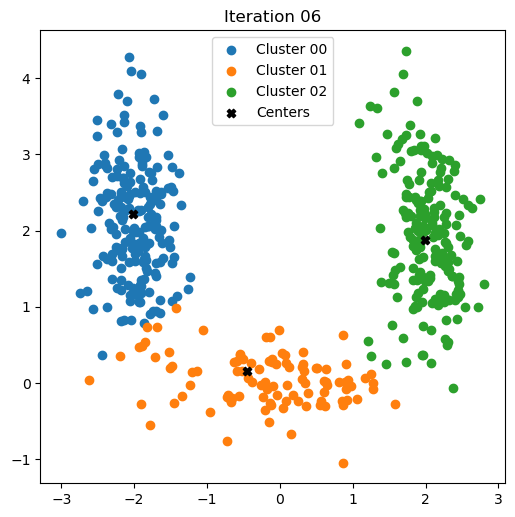

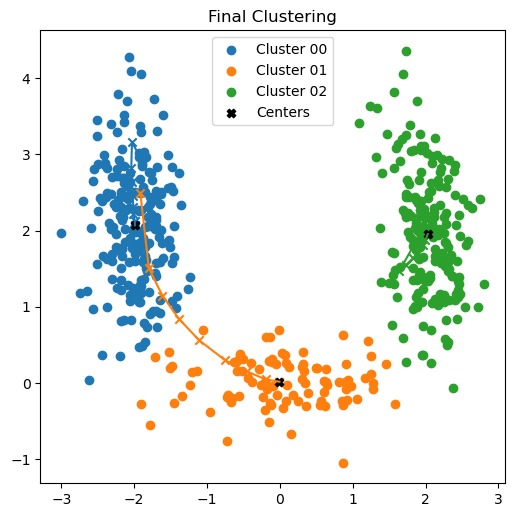

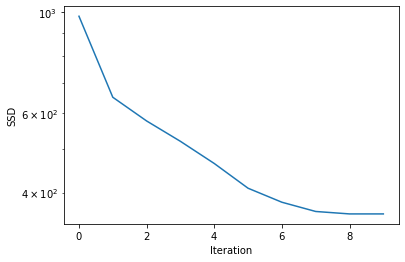

In [4]:
data = np.load("samples_u.npy")  # choose samples_1.npy, samples_2.npy, samples_3.npy, samples_u.npy
seed = 42
k = 3

np.random.seed(seed)
cluster_labels, centers, ssd_history, centers_history = k_means(data, k)

# plot final clustering with history of centers over iterations
visualize_2d_clustering(data, cluster_labels, centers, k=k, centers_history=centers_history, title="Final Clustering")

# plot SSD
plt.figure("SSD")
plt.semilogy(ssd_history)
plt.xlabel("Iteration")
plt.ylabel("SSD")
plt.show()

## 2.) Expectation Maximization for Gaussian Mixture Models (7 Points)

In this exercise, we implement the expectation aximization (EM) algorithm to fit a Gaussian mixture model (GMM) to data. We start with an implementation of the log-density of a single Gaussian. We already saw an implementation of this in the first exercise and noted there that it was not the "proper" way of doing it. Here, we provide a better implementation. Compare the two implementations.

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from typing import Tuple

In [6]:
def gaussian_log_density(samples: np.ndarray, mean: np.ndarray, covariance: np.ndarray) -> np.ndarray:
    """
    Computes the log-density of samples under a Gaussian distribution in a stable and efficient manner.    
    :param samples: samples (shape: [N x dim])
    :param mean: mean of the distribution (shape: [dim])
    :param covariance: covariance of the distribution (shape: [dim x dim])
    :return: log N(x | mean, covariance) (shape: [N])
    """
    dim = mean.shape[0]

    # Recall:
    #  log N(x | mu, Sigma) = - 0.5 * dim * log(2pi) 
    #                         - 0.5 * log det Sigma 
    #                         - 0.5 * (x - mu)^T Sigma^(-1) (x - mu)

    # Everything is more stable using the Cholesky decomposition!
    #  Sigma = L^T L, where L is lower triangular
    chol_covariance = np.linalg.cholesky(covariance)

    # compute constant term: -0.5 * dim * log(2pi)
    const_term = dim * np.log(2 * np.pi)  # float
    
    # compute log-determinant: -0.5 * log det Sigma = -0.5 * log prod diag(L)
    logdet_term = 2 * np.sum(np.log(np.diagonal(chol_covariance) + 1e-25))  # (N,)
    
    # compute exponential term: 
    #  (x - mu)^T Sigma^(-1) (x - mu) = ((x - mu) L^(-1))^T * (L^(-1) (x - mu))
    diff = samples - mean[None, :]  # shape (N, dim)
    sol = scipy.linalg.solve_triangular(chol_covariance, diff.T, lower=True).T  # (N, dim)
    exp_term = np.sum(np.square(sol), axis=-1)  # (N,)
    return -0.5 * (const_term + logdet_term + exp_term)

We also provide some plotting functionaliy for $2D$ GMMs: 

In [7]:
def visualize_2d_gmm(samples, weights, means, covs, title):
    """Visualize the model and the samples."""
    plt.figure(figsize=[7,7])
    plt.title(title)
    plt.scatter(samples[:, 0], samples[:, 1], label="Samples", c=next(plt.gca()._get_lines.prop_cycler)['color'])

    for i in range(means.shape[0]):
        c = next(plt.gca()._get_lines.prop_cycler)['color']

        (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(covs[i])
        phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

        plt.scatter(means[i, 0:1], means[i, 1:2], marker="x", c=c)

        a = 2.0 * np.sqrt(largest_eigval)
        b = 2.0 * np.sqrt(smallest_eigval)

        ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
        ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

        R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
        r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
        plt.plot(means[i, 0] + r_ellipse[:, 0], means[i, 1] + r_ellipse[:, 1], c=c,
                 label="Component {:02d}, Weight: {:0.4f}".format(i, weights[i]))
    plt.legend()

For this exercise, you need to implement 4 functions:
- The log joint densities $\log \left( p(x | z = k) p(z = k) \right)$ for all components $k$ of a GMM,
- the log-likelihood $\log p(x) = \log \sum_k p(x | z = k) p(z = k) $ of a GMM,
- the E-Step of the EM algorithm for GMMs,
- the M-Step of the EM algorithm for GMMs.

***Hints***:
- for-loops are only allowed in ```log_joint_densities()```!
- Consider using the ```logsumexp```-trick for a stable implementation of ```gmm_log_likelihood()```.

In [8]:
def compute_log_joint_densities(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    """
    Computes the log joint densities of samples under a GMM, given model parameters.    
    :param samples: samples (shape: [N x dim])
    :param weights: mixture weights, i.e., p(z) (shape: [num_components])
    :param means: component means, i.e., means of p(x|z) (shape: [num_components, dim])
    :param covariances: component covariances, i.e., means of p(x|z) (shape: [num_components, dim, dim])
    :return: log joint densities, i.e., log (p(x|z = k)p(z = k)) (shape: [N, k])
    """
    ############################################################
    # TODO: Compute the log joint densities log ( p(x_n | z = k) p(z = k) ) of a GMM.
    
    ## SOLUTION ################################################
    # compute log component densities: log p(x_n | z = k) = log N(x_n | mu_k, cov_k)
    log_component_densities = []
    for i in range(len(weights)):
        log_component_densities.append(gaussian_log_density(samples, means[i], covariances[i]))
    log_component_densities = np.stack(log_component_densities, -1) # shape (N, k)
    
    # compute log joint densities: log p(x_n, z = k) = log p(x_n | z = k) + log p(z = k)
    log_joint_densities = log_component_densities + np.log(weights[None, :])  # shape (N, k)
    ############################################################
    
    return log_joint_densities
    
def compute_gmm_log_likelihood(log_joint_densities: np.ndarray) -> np.ndarray:
    """ 
    Computes the log-likelihood of a GMM based on the log joint densities.
    :param log_joint_densities: log joint densities, i.e., log p(x | z = k) p(z = k) (shape: [N, k])
    :param weights: mixture weights, i.e., p(z) (shape: [num_components])
    :return: log-likelihood, i.e., log p(x_n) = log sum_k p(x_n | z = k) p(z = k) (shape: [N])
    """
    ############################################################
    # TODO: Implement the log-likelihood log p(x_n) = log sum_k p(x_n | z = k) p(z = k) for GMMs.

    ## SOLUTION ################################################ 
    # 1.) without log_sum_exp trick
    # marginal_densities = np.log(np.sum(np.exp(log_joint_densities), axis=1))
    
    # 2.) with log_sum_exp trick 
    # We would like to avoid computing the bare densities np.exp(log_joint_densities)
    #  and rather stay in log-space to avoid numerical underflow (p(x_n) might be 
    #  numerically zero and hence log p(x_n) might be undefined).
    # Thus, subtract a_n := max_k log p(x_n, z = k) from the log p(x_n, z = k), s.t.,
    #  log sum_k exp log p(x_n, z=k) 
    #  = log sum_k exp (log p(x_n, z=k) - a_n + a_n)
    #  = log [ exp a_n * sum_k exp (log p(x_n, z=k) - a_n) ]
    #  = a_n + log sum_k exp (log p(x_n, z=k) - a_n)
    # Note that we avoid numerical underflow as one term in the sum is ensured to equal 1.
    a = np.max(log_joint_densities, axis=1, keepdims=True)  # shape (N, 1)
    marginal_densities = np.squeeze(a) + np.log(np.sum(np.exp(log_joint_densities - a), 1))  # shape (N,)
    ############################################################
   
    return marginal_densities


def e_step(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    """
    E-Step of EM for fitting GMMs. Computes responsibilities, p(z|x), given samples and model parameters.
    :param samples: samples on which to compute the responsibilities (shape: [N, dim])
    :param weights: weights (i.e., p(z)) of model (shape: [num_components])
    :param means: means of components p(x|z) (shape: [num_components, dim])
    :param covariances: covariances of model components p(x|z) (shape: [num_components, dim, dim])
    :return: responsibilities p(z|x) (shape: [N x num_components])
    """
    ############################################################
    # TODO Implement the E-Step of EM for GMMs.

    ## SOLUTION ################################################
    log_joint_densities = compute_log_joint_densities(samples, weights, means, covariances)  # shape (N, k)

    # compute log p(z = k | x_n) = log p(x_n, z = k) - log p(x_n)
    log_responsibilities = log_joint_densities - compute_gmm_log_likelihood(log_joint_densities)[:, None]  # shape (N, k)
    ############################################################
    
    return np.exp(log_responsibilities)
    

def m_step(samples: np.ndarray, responsibilities: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    M-Step of EM for fitting GMMs. Computes new parameters given samples and responsibilities p(z|x).
    :param samples: samples (shape: [N, dim])
    :param responsibilities: p(z|x) (shape: [N x num_components])
    :return: - new weights p(z) (shape: [num_components])
             - new means of components p(x|z) (shape: [num_components, dim])
             - new covariances of components p(x|z) (shape: [num_components, dim, dim]
    """
    #########################################################
    # TODO: Implement the M-Step for EM for GMMs.

    ## SOLUTION ################################################
    N = samples.shape[0]
    # k = responsibilities.shape[1]
    # d = samples.shape[1]
    
    # update weights: N_k := sum_n p(z=k | x_n), pi_k = N_k / N
    N_k = np.sum(responsibilities, axis=0)  # shape (k,)
    new_weights = N_k / N

    # update component means: mu_k = sum_n p(z=k | x_n) / N_k * x_n
    sample_weights = responsibilities / N_k[None, :]  # shape (N, k)
    weighted_samples = sample_weights[:, :, None] * samples[:, None, :]  # shape (N, k, d)
    new_means = np.sum(weighted_samples, axis=0)  # shape (k, dim)

    # update component covariances: Sigma_k = sum_n p(z = k | x_n) / N_k * (x_n - mu_k)(x_n - mu_k)^T
    diffs = samples[:, None, :] - new_means[None, :, :]  # shape (N, k, d)
    outer_products = diffs[:, :, None, :] * diffs[:, :, :, None]  # shape (N, k, d, d)
    weighted_outer_products = sample_weights[:, :, None, None] * outer_products   # shape (N, k, d, d)
    new_covs = np.sum(weighted_outer_products, axis=0)   # shape (k, d, d)
    #########################################################

    return new_weights, new_means, new_covs 

Now we can implement the EM-algorithm to fit a GMM to data.

In [9]:
def fit_gaussian_mixture(samples: np.ndarray, num_components: int, num_iters: int = 30, vis_interval: int = 5):
    """
    Fit a Gaussian Mixture Model using the Expectation Maximization Algorithm.
    :param samples: samples to fit the GMM to (shape: [N, dim])
    :param num_components: number of components of the GMM
    :param num_iters: number of iterations
    :param vis_interval: after how many iterations to generate the next plot
    :return: - final weights p(z) (shape: [num_components])
             - final means of components p(x|z) (shape: [num_components, dim])
             - final covariances of components p(x|z) (shape: [num_components, dim, dim])
             - log_likelihoods: log-likelihood of data under model after each iteration (shape: [num_iters])
    """
    # Initialize model: 
    #  We initialize with means randomly picked from the data, unit covariances and uniform
    #  component weights. In general, smarter initialization techniques might be necessary, e.g., k-Means.
    initial_idx = np.random.choice(len(samples), num_components, replace=False)
    means = samples[initial_idx]
    covs = np.tile(np.eye(data.shape[-1])[None, ...], [num_components, 1, 1])
    weights = np.ones(num_components) / num_components

    # bookkeeping
    log_likelihoods = np.zeros(num_iters + 1)

    # iterate E- and M-steps
    for i in range(num_iters):
        # plotting, bookkeeping
        if i % vis_interval == 0:
            visualize_2d_gmm(data, weights, means, covs, title="Before Iteration {:02d}".format(i))            
        log_likelihoods[i] = np.mean(compute_gmm_log_likelihood(compute_log_joint_densities(samples, weights, means, covs)))
            
        # perform step
        responsibilities = e_step(samples, weights, means, covs)
        weights, means, covs = m_step(samples, responsibilities)
    
    # final plotting, bookkeeping
    visualize_2d_gmm(data, weights, means, covs, title="Final model".format(i))            
    log_likelihoods[-1] = np.mean(compute_gmm_log_likelihood(compute_log_joint_densities(samples, weights, means, covs)))
        
    return weights, means, covs, log_likelihoods

Finally we load some data and run the algorithm. Again, feel free to play around with the parameters a bit. 

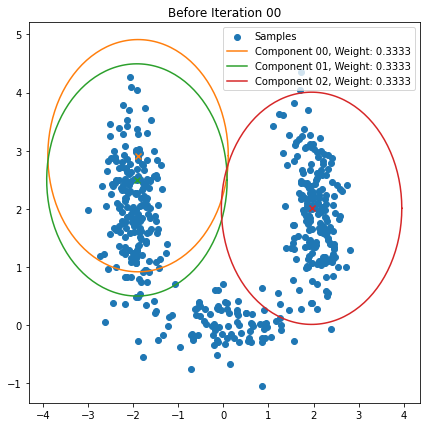

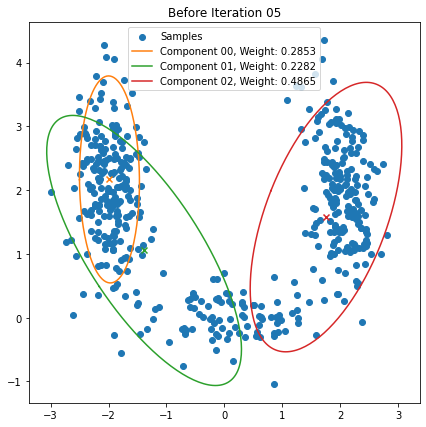

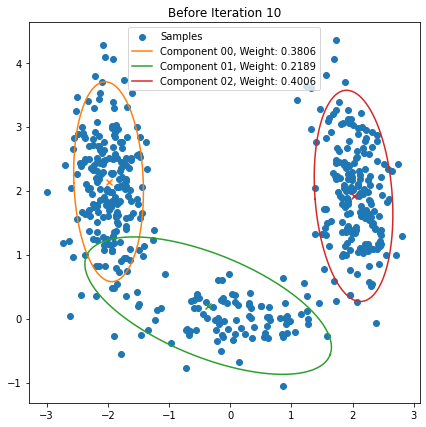

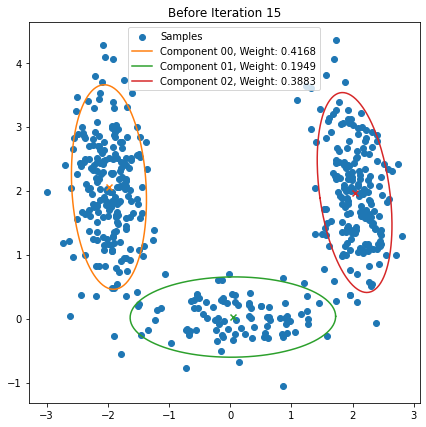

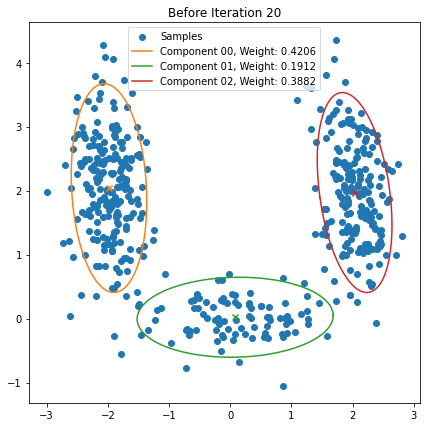

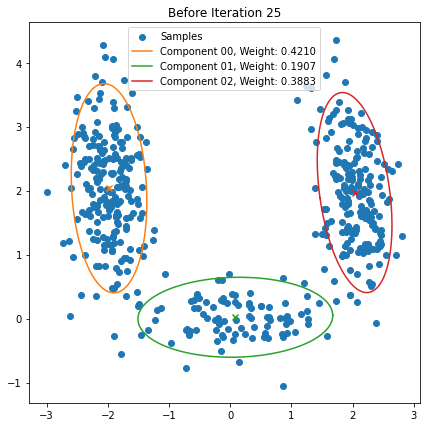

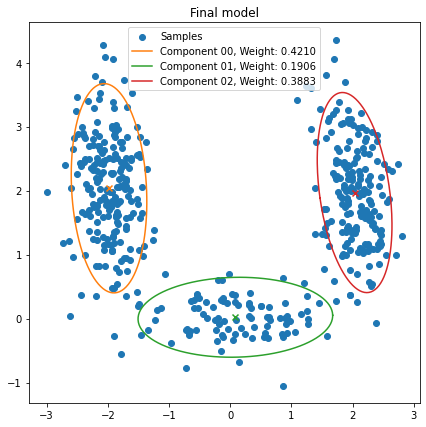

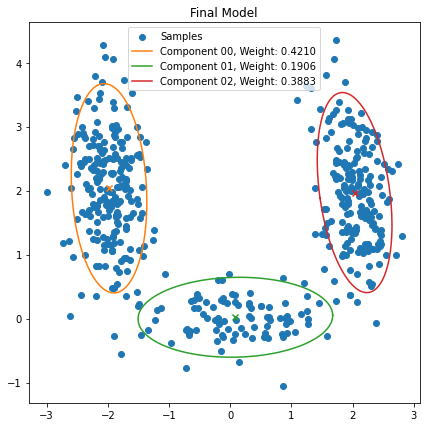

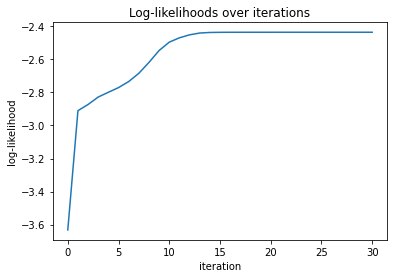

In [10]:
# hyperparameters
seed = 42
num_components = 3
num_iters = 30
vis_interval = 5

# dataset
data = np.load("samples_u.npy")   # choose between samples_1.npy, samples_2.npy, samples_3.npy, samples_u.npy.

# running and ploting
np.random.seed(seed)
final_weights, final_means, final_covariances, log_likeihoods = \
    fit_gaussian_mixture(data, num_components, num_iters, vis_interval)
visualize_2d_gmm(data, final_weights, final_means, final_covariances, title="Final Model")

plt.figure()
plt.title("Log-likelihoods over iterations")
plt.plot(log_likeihoods)
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

## 3.) Probabilistic PCA with Expectation Maximization (7 Points)

In this exercise, we will implement probabilistic PCA (PPCA) as discussed in the lecture. We will apply it on a toy task and the handwritten digit data set. We will also generate our own images. 

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import Union, Optional

We start by defining some utilities for plotting. You don't need to do anything here.

In [20]:
def plot_data(X):
    plt.scatter(X[:, 0], X[:, 1], color='b')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 7)
    plt.ylim(0, 7)

def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)

def plot_ev(mu, eig_vec_1, eig_vec_2):
    arrow_1_end = mu + eig_vec_1
    arrow_1_x = [mu[0], arrow_1_end[0]]
    arrow_1_y = [mu[1], arrow_1_end[1]]

    arrow_2_end = mu + eig_vec_2
    arrow_2_x = [mu[0], arrow_2_end[0]]
    arrow_2_y = [mu[1], arrow_2_end[1]]

    plt.plot(mu[0], mu[1], 'xr')
    plt.plot((mu + eig_vec_1)[0], (mu + eig_vec_1)[1], 'xr')
    plt.plot(arrow_1_x, arrow_1_y, 'red')
    plt.plot(arrow_2_x, arrow_2_y, 'red')

### Exercise 3.1) E-Step in Probabilistic PCA (3 Points)
We will implement the E-step in this exercise. Remember the equations in the E-Step read
\begin{align*}
    \boldsymbol{\mu}_{\boldsymbol{z}|\boldsymbol{x}_i} &= (\boldsymbol{W^TW}+\sigma^2\boldsymbol{I})^{-1}\boldsymbol{W}^T(\boldsymbol{x}_i-\boldsymbol{\mu}) \\
     \boldsymbol{\Sigma_{\boldsymbol{z}|\boldsymbol{x}_i}} &=\sigma^2(\boldsymbol{W^TW}+\sigma^2\boldsymbol{I})^{-1},
\end{align*}
where $\boldsymbol{x}_i$ is one sample of the data, $\boldsymbol{W}$ is the transformation matrix, $\sigma^2$ is the variance and $\boldsymbol{\mu}$ is the mean of the likelihood model.

Implement the E-step of the EM-Algorithm for dimensionality reduction, according to the equations stated.

***Hint***: 
- As always, avoid matrix inversions if possible!
- Use the Cholesky decomposition to sample from a multivariate Gaussian.

In [13]:
def e_step(W: np.ndarray, mu: np.ndarray, X: np.ndarray, sigma_quad: float):
    """
    Compute posterior parameters and samples, given transformation matrix W and data X.
    :param W: transformation matrix W (shape: [DxM], where D is data dimension, M is latent dimension)
    :param X: data matrix containing the data (shape: [NxD])
    :param sigma_quad: sigma^2, the variance of the likelihood (shape: float)
    :return: - mu_z, the mean of the posterior for each sample x (shape: [NxM])
             - z_samples, the latent variables (shape: [NxM])
             - cov_z, the covariance of the posterior (shape: [MxM])
    """
    ############################################################
    # TODO: Implement the E-step for PPCA
    
    ## SOLUTION ################################################
    temp = W.T @ W + sigma_quad * np.eye(W.shape[-1])
    mu_z = (np.linalg.solve(temp, W.T)@(X-mu).T).T
    cov_z = np.linalg.solve(temp, sigma_quad * np.eye(W.shape[-1]))

    L_z = np.linalg.cholesky(cov_z)

    # [M*N]
    # z_samples = (mu_z + (L_z @ np.random.normal(0, 1, mu_z.shape).T).T).T

    # [N*M]
    z_samples = (mu_z + (L_z @ np.random.normal(0, 1, mu_z.shape).T).T)
    ############################################################
    return mu_z, z_samples, cov_z

### Exercise 3.2) M-Step in Probabilistic PCA (4 Points)
Now, we implement the M-step. Recall the following equations from the lecture,
\begin{align*}
    \left(
    \begin{array}{c}
    \boldsymbol{\mu}\\
    \boldsymbol{W}
    \end{array}
    \right) = (\boldsymbol{Z^TZ})^{-1}\boldsymbol{Z}^T\boldsymbol{X},
\end{align*}
where 
\begin{align*}
\boldsymbol{X}=
    \left(
    \begin{array}{c}
    \boldsymbol{x}_1^T\\
    \vdots\\
    \boldsymbol{x}_n^T
    \end{array}
    \right),
\boldsymbol{Z}=
    \left(
    \begin{array}{c}
    1, \boldsymbol{z}_1^T\\
    \vdots\\
    1, \boldsymbol{z}_n^T
    \end{array}
    \right).
\end{align*}
Here, $\boldsymbol{Z}$ is the matrix containing the bias and all the latent variable samples $\boldsymbol{z}_i$ and $\boldsymbol{X}$ is the matrix containing all data points $\boldsymbol{x}$. 
We further need to implement the variance:
\begin{align*}
    \sigma^2 = \frac{1}{ND}\sum_{i=1}^{N}\sum_{k=1}^{D}(y_{ik}- x_{ik})^2,
\end{align*}
where $\boldsymbol{y}_i=\boldsymbol{W}\boldsymbol{z}_i + \boldsymbol{\mu}$ and N is the number of data points and D is the dimension of the data $\boldsymbol{x}$. 

***Hint***: as always, avoid matrix inversions!

In [14]:
def m_step(z_samples: np.ndarray, X: np.ndarray):
    """
    Computes the variance and the transformation matrix W given the latent vectors in z_samples and the data 
    in matrix X.
    :param Z: latent variable vectors stored in z_samples (shape: [NxM])
    :param X: matrix containg the data (shape: [NxD])
    :return: the variance sigma_quad (shape: float), and the transformation matrix W (shape: [DxM]) 
    """
    #############################################################################################################
    # TODO: Implement the M-step for PPCA
    
    ## SOLUTION ################################################
    # Apply one more transpose if z_samples has shape [M*N]
    # z_samples = z_samples.T

    # create feature matrix Z
    Z = np.hstack([np.ones(shape=[X.shape[0], 1]), z_samples])    # [N, M+1]
    W_tilde = (np.linalg.solve(Z.T @ Z, Z.T) @ X).T
    mu = W_tilde[:, 0]
    W = W_tilde[:, 1:]
    sigma_quad = np.mean(((W @ z_samples.T).T + mu - X)**2)
    ############################################################
    return sigma_quad, mu, W

This is the EM-loop, where the E-step and the M-step alternates. You do not need to implement anything here.

In [15]:
def do_ppca(X: np.ndarray, n_principle_comps: int, num_iters: int = 50):
    np.random.seed(0)
    W = np.random.normal(size=(X.shape[1], n_principle_comps))
    mu_X = np.mean(X, axis=0)
    mu = mu_X.copy()
    sigma_quad = 1
    for i in range(num_iters):
        mu_z, z_samples, var_z = e_step(W, mu, X, sigma_quad)
        sigma_quad, mu, W = m_step(z_samples, X)
    return W, z_samples, var_z, sigma_quad, mu

### 2D Toy Task
We will first apply PPCA on the toy task, which we also studied in the lecture. Here is the data:

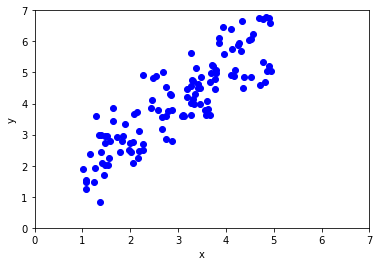

In [16]:
np.random.seed(0)

x = np.random.uniform(1,5, size=(120, 1))
y = x + 1 + np.random.normal(0, 0.7, size=x.shape)

X = np.concatenate((x, y), axis = 1)
plot_data(X)

Let's now perform the algorithm on the data. You do not need to change anything. 

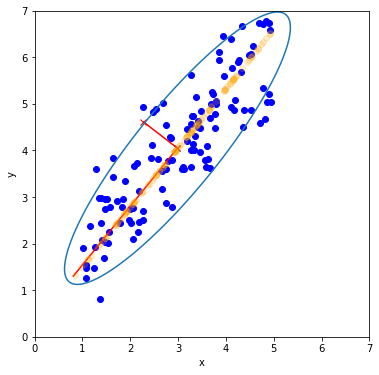

In [17]:
plt.figure(figsize=(6,6))

plot_data(X)

W, z_samples, var_z, sigma_quad, mu = do_ppca(X, n_principle_comps=1)

x_tilde = np.dot(W, z_samples.T).T + mu                         # reproject to high-dim space

C = np.dot(W, W.T) + sigma_quad*np.eye(W.shape[0])      # covariance of p(x) (reconstructed)

v, U = np.linalg.eig(np.cov(X.T))
mu_X = np.mean(X, axis=0)
plot_ev(mu_X, 2*np.sqrt(v[0])*U[:, 0], 2*np.sqrt(v[1])*U[:, 1])

draw_2d_gaussian(mu_X, C)

plt.plot(x_tilde[:, 0], x_tilde[:, 1], 'o', color='orange', alpha=0.2)   # reprojected data points

### Hand-Written Digits
Next, we apply PPCA on the handwritten digits data set. We will consider the digit 3 only. Here is how the data looks like:

In [18]:
from sklearn.datasets import load_digits

digits = load_digits()
targets = digits.target

# get the images for digit 3 only
digits_3_indx = np.where(targets == 3)[0]
digit_3_data = digits.data[digits_3_indx]       # shape: (183, 64)  -> (8 x 8)
digit_3_targets = digits.target[digits_3_indx]       # only needed to verify that we load digit 3

mu_X_im = np.mean(digit_3_data, axis=0)

# plot the original digit 3 images
plt.figure()
fig, axes = plt.subplots(10, 10, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
     ax.imshow(digit_3_data[i].reshape(8, 8))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Let's perform PPCA on the data
n_principle_comps = 10
W_im, z_samples_im, var_z_im, sigma_quad_im, mu_im = do_ppca(digit_3_data, n_principle_comps=n_principle_comps)
x_tilde_im = np.dot(W_im, z_samples_im.T).T + mu_im

considered_im = digit_3_data[15]
considered_im_x_tilde = x_tilde_im[15, :]

plt.figure()
plt.subplot(121)
plt.title('Original')
plt.imshow(considered_im.reshape(8, 8))

plt.subplot(122)
plt.title('Reprojection')
plt.imshow(considered_im_x_tilde.reshape(8,8))
plt.show()

Although the reprojected data does not look same, you should definitely see the similarity to the original image.

### Random Image Generation
One advantage of PPCA is that we can generate random images. The generative process, as described in the lecture, is implemented here.

In [ ]:
# Sample some vectors z
z = np.random.normal(size=(5, n_principle_comps))

# Project back to D-dim space
y = np.dot(W_im, z.T).T + mu_im

# Sample noise
eps = np.random.normal(scale=sigma_quad, size=y.shape)

# Get image
x = y + eps

# Visualize
plt.figure('Sampled Image')
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
     ax.imshow(x[i].reshape(8, 8))